<a href="https://colab.research.google.com/github/deepanshukla/credit-risk-analysis/blob/main/credit-risk-analysis-n-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
def load_data(path):
    if path.endswith('.xls') or path.endswith('.xlsx'):
        df = pd.read_excel(path, header=1)
    else:
        raise ValueError("Unsupported file format. Please provide a .xls, or .xlsx file.")
    # df = df.drop(df.index[0])
    df.reset_index(drop=True, inplace=True)
    if 'default payment next month' in df.columns:
        df.rename(columns={'default payment next month': 'target'}, inplace=True)
    else:
        df.rename(columns={df.columns[-1]: 'target'}, inplace=True)

    return df

def preprocess(df, dataset='uci'):
    df = df.copy()
    if dataset == 'uci':
        if 'ID' in df.columns:
            df.drop(columns=['ID'], inplace=True)
        df = df[df['target'].isin([0, 1])]
        df['target'] = df['target'].astype(int)

        df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
        df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})

        scale_cols = ['LIMIT_BAL'] + \
                     [f'BILL_AMT{i}' for i in range(1, 7)] + \
                     [f'PAY_AMT{i}' for i in range(1, 7)]

        scaler = StandardScaler()
        df[scale_cols] = scaler.fit_transform(df[scale_cols])

    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    df = df.dropna()
    df['target'] = df['target'].astype(int)
    return df

def split_and_resample(df):
    X = df.drop('target', axis=1)
    y = df['target']

    # Split with stratification to maintain target distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

In [4]:
def get_models():
    return {
        'Logistic Regression': LogisticRegression(max_iter=200, solver='liblinear'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
    }

In [5]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, probas),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=False)
    }

def plot_roc_curves(models, X_test, y_test, path=None):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        probas = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, probas)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    if path:
        plt.savefig(path)
    plt.show()

def plot_pr_curves(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        probas = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, probas)
        plt.plot(recall, precision, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

def explain_with_shap(model, X):
    explainer = shap.Explainer(model)
    shap_values = explainer(X[:100])
    shap.plots.beeswarm(shap_values)


In [6]:
# Load and preprocess dataset
uci_path = r"/content/UCI_Credit_Card.xls"
df = load_data(uci_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [7]:
df = preprocess(df, dataset='uci')
X_train, X_test, y_train, y_test = split_and_resample(df)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



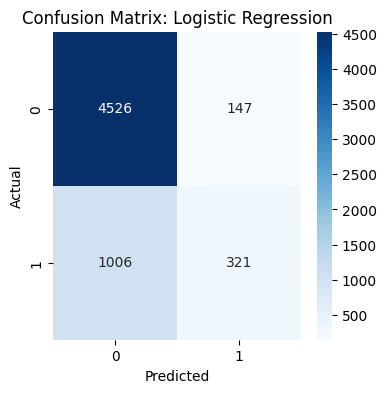


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



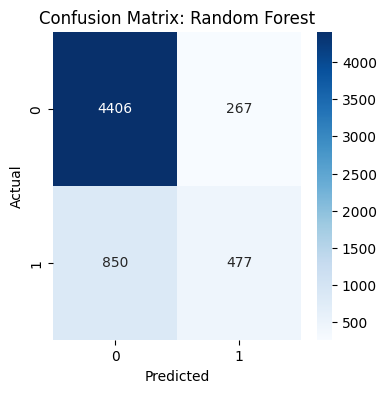


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      4673
           1       0.45      0.55      0.50      1327

    accuracy                           0.75      6000
   macro avg       0.66      0.68      0.67      6000
weighted avg       0.77      0.75      0.76      6000



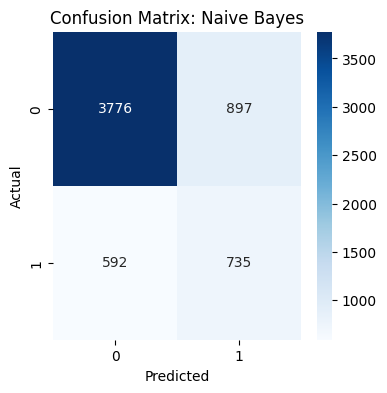

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4673
           1       0.61      0.36      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



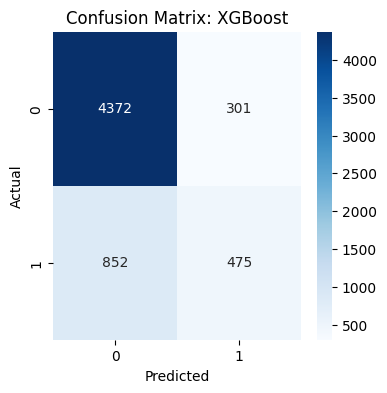


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



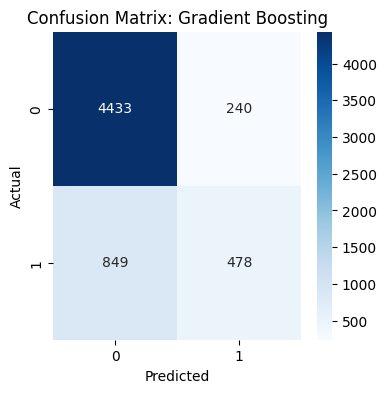


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4673
           1       0.54      0.34      0.42      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.63      0.64      6000
weighted avg       0.77      0.79      0.77      6000



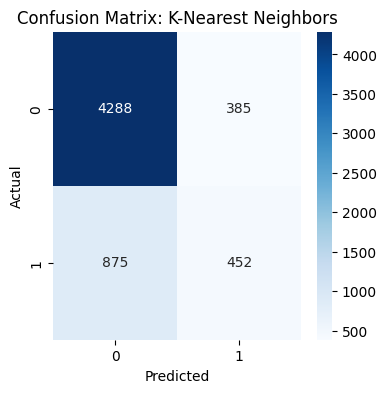

In [8]:
models = get_models()
fitted_models = {}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    metrics = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'F1': metrics['f1'],
        'ROC-AUC': metrics['roc_auc']
    })
    print(f"\n{name} Classification Report:\n{metrics['classification_report']}")
    plot_confusion_matrix(metrics['confusion_matrix'], name)

/tmp/ipython-input-11-181735481.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df.sort_values(by='Accuracy', ascending=False), ax=axes[0], palette='Blues_d')
/tmp/ipython-input-11-181735481.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Model', data=results_df.sort_values(by='F1', ascending=False), ax=axes[1], palette='Greens_d')
/tmp/ipython-input-11-181735481.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC-AUC', y='Model', data=results_df.sort_values(by='ROC-AUC', asce

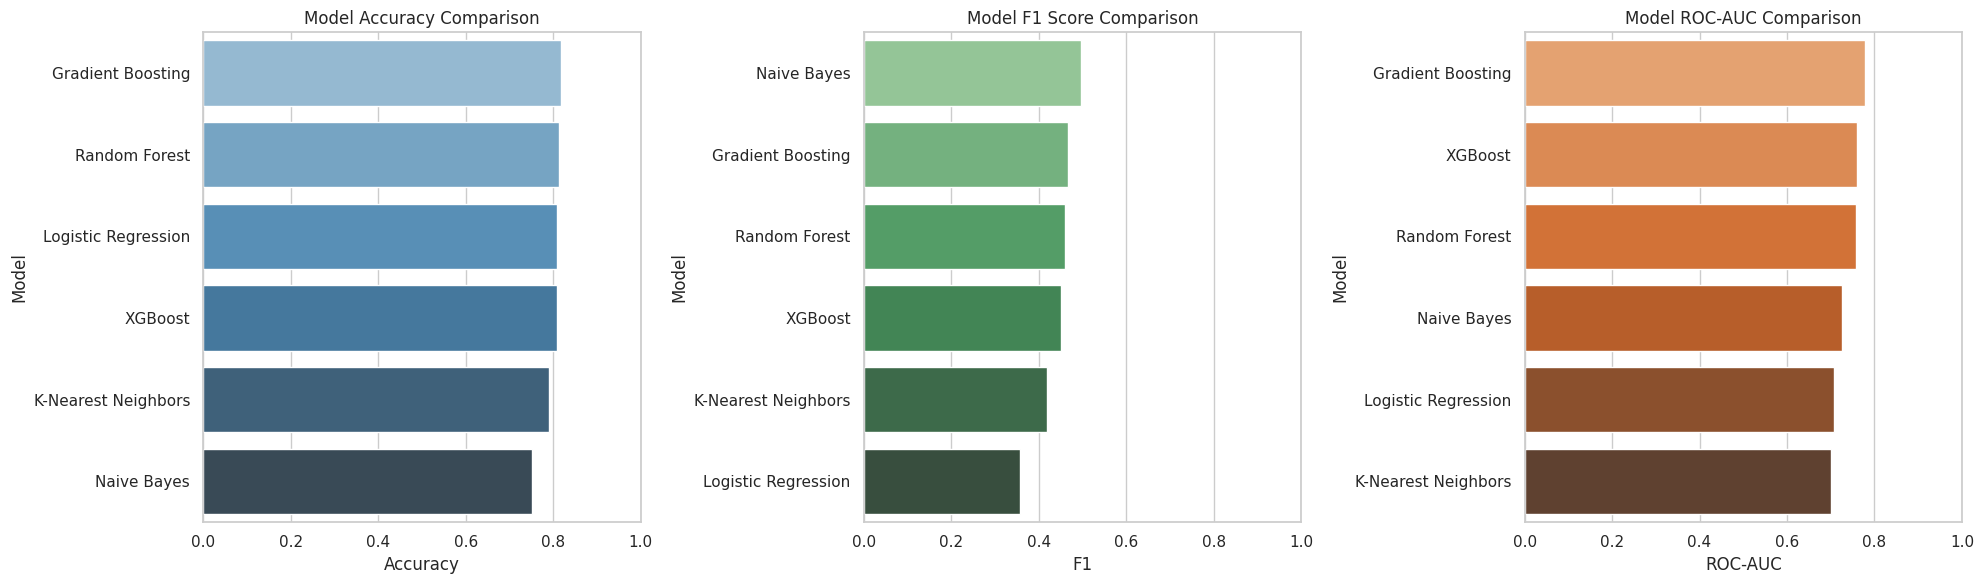

In [11]:
results_df = pd.DataFrame(results)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

#Accuracy
sns.barplot(x='Accuracy', y='Model', data=results_df.sort_values(by='Accuracy', ascending=False), ax=axes[0], palette='Blues_d')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim(0, 1)

#F1 Score
sns.barplot(x='F1', y='Model', data=results_df.sort_values(by='F1', ascending=False), ax=axes[1], palette='Greens_d')
axes[1].set_title('Model F1 Score Comparison')
axes[1].set_xlim(0, 1)

#ROC-AUC
sns.barplot(x='ROC-AUC', y='Model', data=results_df.sort_values(by='ROC-AUC', ascending=False), ax=axes[2], palette='Oranges_d')
axes[2].set_title('Model ROC-AUC Comparison')
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()
